# Unzip the Folder

In [10]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Assignment_for_interview/Dataset/archive.zip' -d '/content/drive/MyDrive/Colab Notebooks/Assignment_for_interview/Dataset'


Archive:  /content/drive/MyDrive/Colab Notebooks/Assignment_for_interview/Dataset/archive.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/Assignment_for_interview/Dataset/test.csv  
  inflating: /content/drive/MyDrive/Colab Notebooks/Assignment_for_interview/Dataset/train.csv  


Task -
1. Understand the dataset
2. Create a classification model using transformer (only fine tuning is needed) method
3. Explain the pre-processing steps and feature engineering method if applicable
4. Explain the evaluation method
5. Write a clear python code using any of the IDE of your choice with comment for individual major steps
6. Do step2-5 with proper understanding as interview questions are based on these steps only
7. Share your working through Github link

In [ ]:
! pip install -q datasets

In [78]:
# !pip install accelerate -U
# !pip install -q transformers[torch]


In [ ]:
!pip install --upgrade --force-reinstall accelerate
# !pip install --upgrade --force-reinstall transformers[torch]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, logging
from datasets import Dataset

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Loading the dataset

In [48]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Assignment_for_interview/Dataset/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Assignment_for_interview/Dataset/test.csv")


In [4]:
df_train.shape , df_test.shape

((120000, 3), (7600, 3))

# Checking for Null Values

In [5]:
df_train.isna().sum() ,'----', df_test.isna().sum()

(Class Index    0
 Title          0
 Description    0
 dtype: int64,
 '----',
 Class Index    0
 Title          0
 Description    0
 dtype: int64)

In [6]:
df_train.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


### Looking for Unique Values in each Title and Description

In [7]:
print(df_train['Title'].nunique())
print(df_train['Description'].nunique())


114350
118723


In [8]:
df_train['Class Index'].replace([1, 2, 3, 4],['World', 'Sports', 'Business', 'Sci/Tech'], inplace=True)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Business'),
  Text(1, 0, 'Sci/Tech'),
  Text(2, 0, 'Sports'),
  Text(3, 0, 'World')])

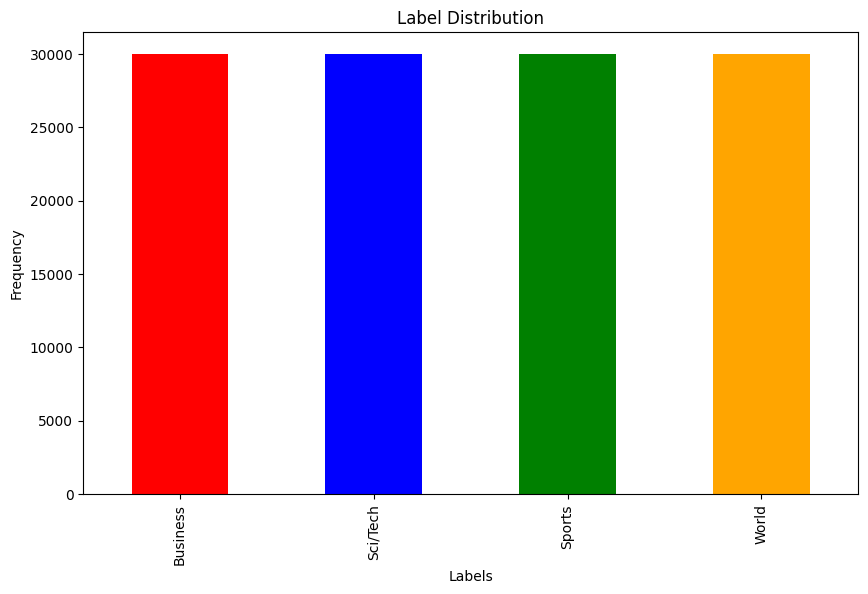

In [9]:
label_counts = df_train['Class Index'].value_counts()
colors = ['red', 'blue', 'green', 'orange']
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=colors[:len(label_counts)])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

In [10]:
df_train['text'] = df_train['Title'] + ' ' + df_train['Description']

In [11]:
df_train.head()

,Class Index,Title,Description,text
0,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [12]:
df_train["Count"] = df_train['text'].apply(lambda x : len(x))

<Figure size 800x800 with 0 Axes>

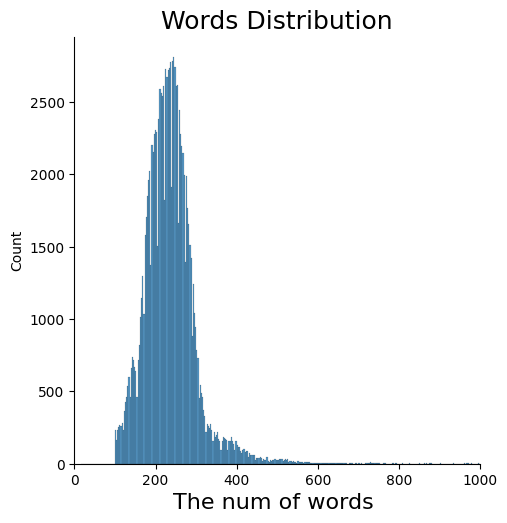

In [13]:
plt.figure(figsize= (8, 8))

sns.displot(df_train['Count'])

plt.xlim(0, 1000)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("Words Distribution", fontsize = 18)
plt.show()

In [14]:
df_train['text'].nunique()

120000

In [15]:
df_train.shape

(120000, 5)

## Relace Category wiht label

In [16]:
df_train['label'] = df_train['Class Index'].astype('category').cat.codes

In [17]:
df_train.head()

,Class Index,Title,Description,text,Count,label
0,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...,144,0
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...,266,0
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...,232,0
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...,256,0
4,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new...",234,0


In [18]:
df_train['label'].value_counts()

0    30000
1    30000
2    30000
3    30000
Name: label, dtype: int64

# Splitting Trainig Data in Train and validation

In [19]:
train_df, val_df = train_test_split(df_train[['text', 'label']],
                                    test_size = 0.2, random_state = 42)

In [20]:
print(train_df.shape,val_df.shape)

(96000, 2) (24000, 2)


#Lodading the model and Tokenization of Input




In [21]:
model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

def data_tokeinzation(data):
    dataset = Dataset.from_pandas(data, preserve_index=False)

    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True)

    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns(["text"])

    return tokenized_dataset



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [22]:
tokenized_train = data_tokeinzation(train_df)
tokenized_val   =  data_tokeinzation(val_df)

Map:   0%|          | 0/96000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

In [23]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [24]:
len(tokenized_train)

96000

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(model, num_labels=4).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
device

device(type='cuda')

# Training Arguments

In [27]:
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy = 'epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    report_to="none",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [28]:
trainer.train()

Step,Training Loss
500,0.399000
1000,0.280300
1500,0.252200
2000,0.234400
2500,0.240200
3000,0.217900
3500,0.211100
4000,0.220000
4500,0.215900
5000,0.204500


TrainOutput(global_step=12000, training_loss=0.1903850663503011, metrics={'train_runtime': 1751.8466, 'train_samples_per_second': 109.599, 'train_steps_per_second': 6.85, 'total_flos': 4821004169804928.0, 'train_loss': 0.1903850663503011, 'epoch': 2.0})

In [ ]:
evaluation_results = trainer.evaluate()

In [66]:
validation_loss = evaluation_results['eval_loss']
print(f"Validation Loss: {validation_loss}")

Validation Loss: 0.1865207552909851


# Preprocessing the Test set and Evaluating Test Set

In [30]:
df_test.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [49]:
df_test['Class Index'].replace([1, 2, 3, 4],['World', 'Sports', 'Business', 'Sci/Tech'], inplace=True)

In [52]:
df_test['label'] = df_test['Class Index'].astype('category').cat.codes

In [50]:
df_test['text'] = df_test['Title'] + ' ' + df_test['Description']

In [53]:
df_test['label'].value_counts()

0    1900
1    1900
2    1900
3    1900
Name: label, dtype: int64

In [54]:
test_df = df_test[['text','label']]

In [55]:
test_df.head()

,text,label
0,Fears for T N pension after talks Unions repre...,0
1,The Race is On: Second Private Team Sets Launc...,1
2,Ky. Company Wins Grant to Study Peptides (AP) ...,1
3,Prediction Unit Helps Forecast Wildfires (AP) ...,1
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,1


In [56]:
tokenized_test = data_tokeinzation(test_df)

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [57]:
tokenized_test = tokenized_test.remove_columns('label')

In [70]:
preds = trainer.predict(tokenized_test)

In [71]:
preds_flat = [np.argmax(x) for x in preds[0]]

In [73]:
from sklearn.metrics import classification_report
report = classification_report(test_df['label'].to_list(), preds_flat, target_names=['World', 'Sports', 'Business', 'Sci/Tech'])
print(report)


              precision    recall  f1-score   support

       World       0.93      0.91      0.92      1900
      Sports       0.91      0.93      0.92      1900
    Business       0.99      0.99      0.99      1900
    Sci/Tech       0.96      0.95      0.96      1900

    accuracy                           0.94      7600
   macro avg       0.94      0.94      0.94      7600
weighted avg       0.94      0.94      0.94      7600



# Saving the Trained Model

In [79]:
save_directory = "/content/drive/MyDrive/model"
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)


('/content/drive/MyDrive/model/tokenizer_config.json',
 '/content/drive/MyDrive/model/special_tokens_map.json',
 '/content/drive/MyDrive/model/vocab.txt',
 '/content/drive/MyDrive/model/added_tokens.json',
 '/content/drive/MyDrive/model/tokenizer.json')

# Checkpoint 2 Loading the Model for Infrence